# EDA

In [1]:
import numpy as np
import pandas as pd
import warnings
import gc
from tqdm import tqdm_notebook
import xgboost as xgb
import lightgbm as lgb
from scipy.sparse import vstack, csr_matrix, save_npz, load_npz
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
warnings.filterwarnings("ignore")
gc.enable()
sns.set()

In [2]:
pd.set_option('max_rows', 200)
pd.set_option('max_colwidth', 500)
pd.set_option('max_columns', 500)

## Data Load

In [30]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
train.shape, test.shape

((200000, 202), (200000, 201))

In [31]:
train, cv_test = train_test_split(train, test_size=0.1)

## Null Test

In [5]:
train.isna().any().any()

False

In [6]:
test.isna().any().any()

False

## EDA

In [6]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

Distributions of first 30 columns


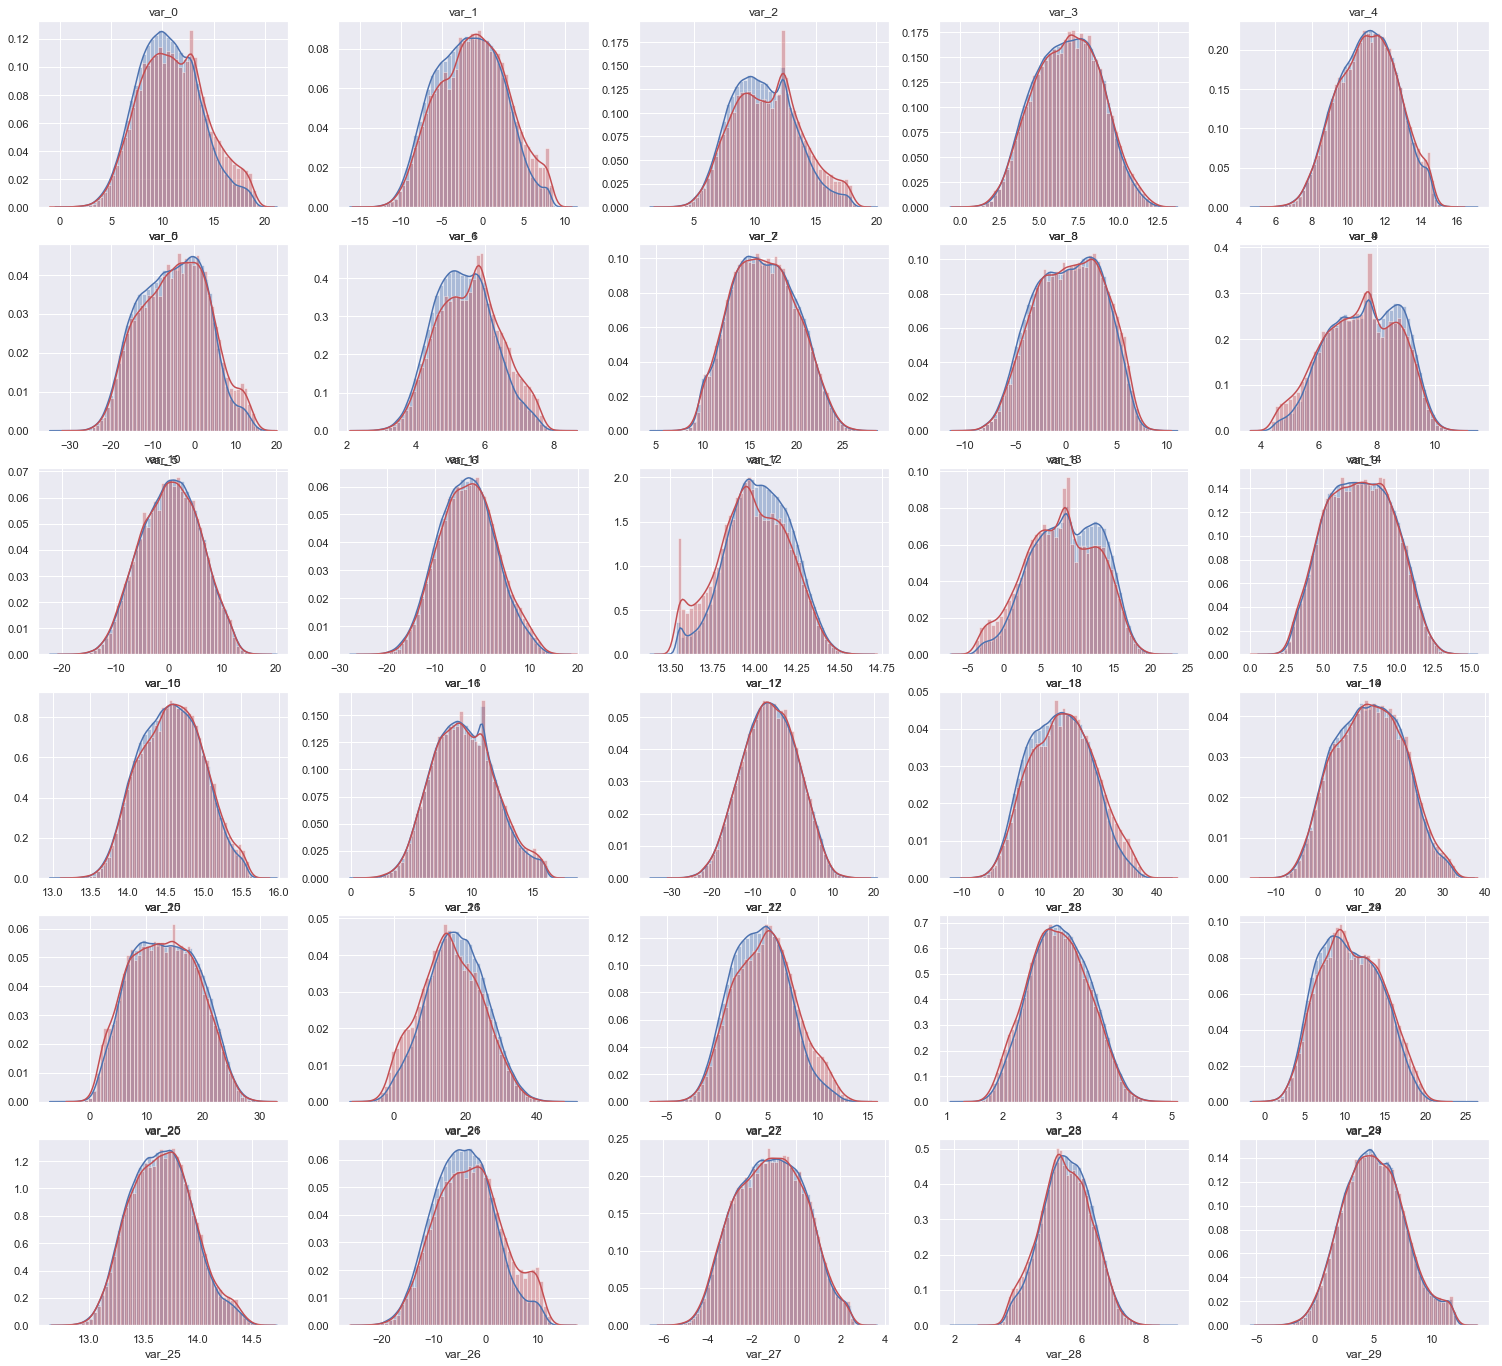

In [248]:
idx = 0
print('Distributions of first 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


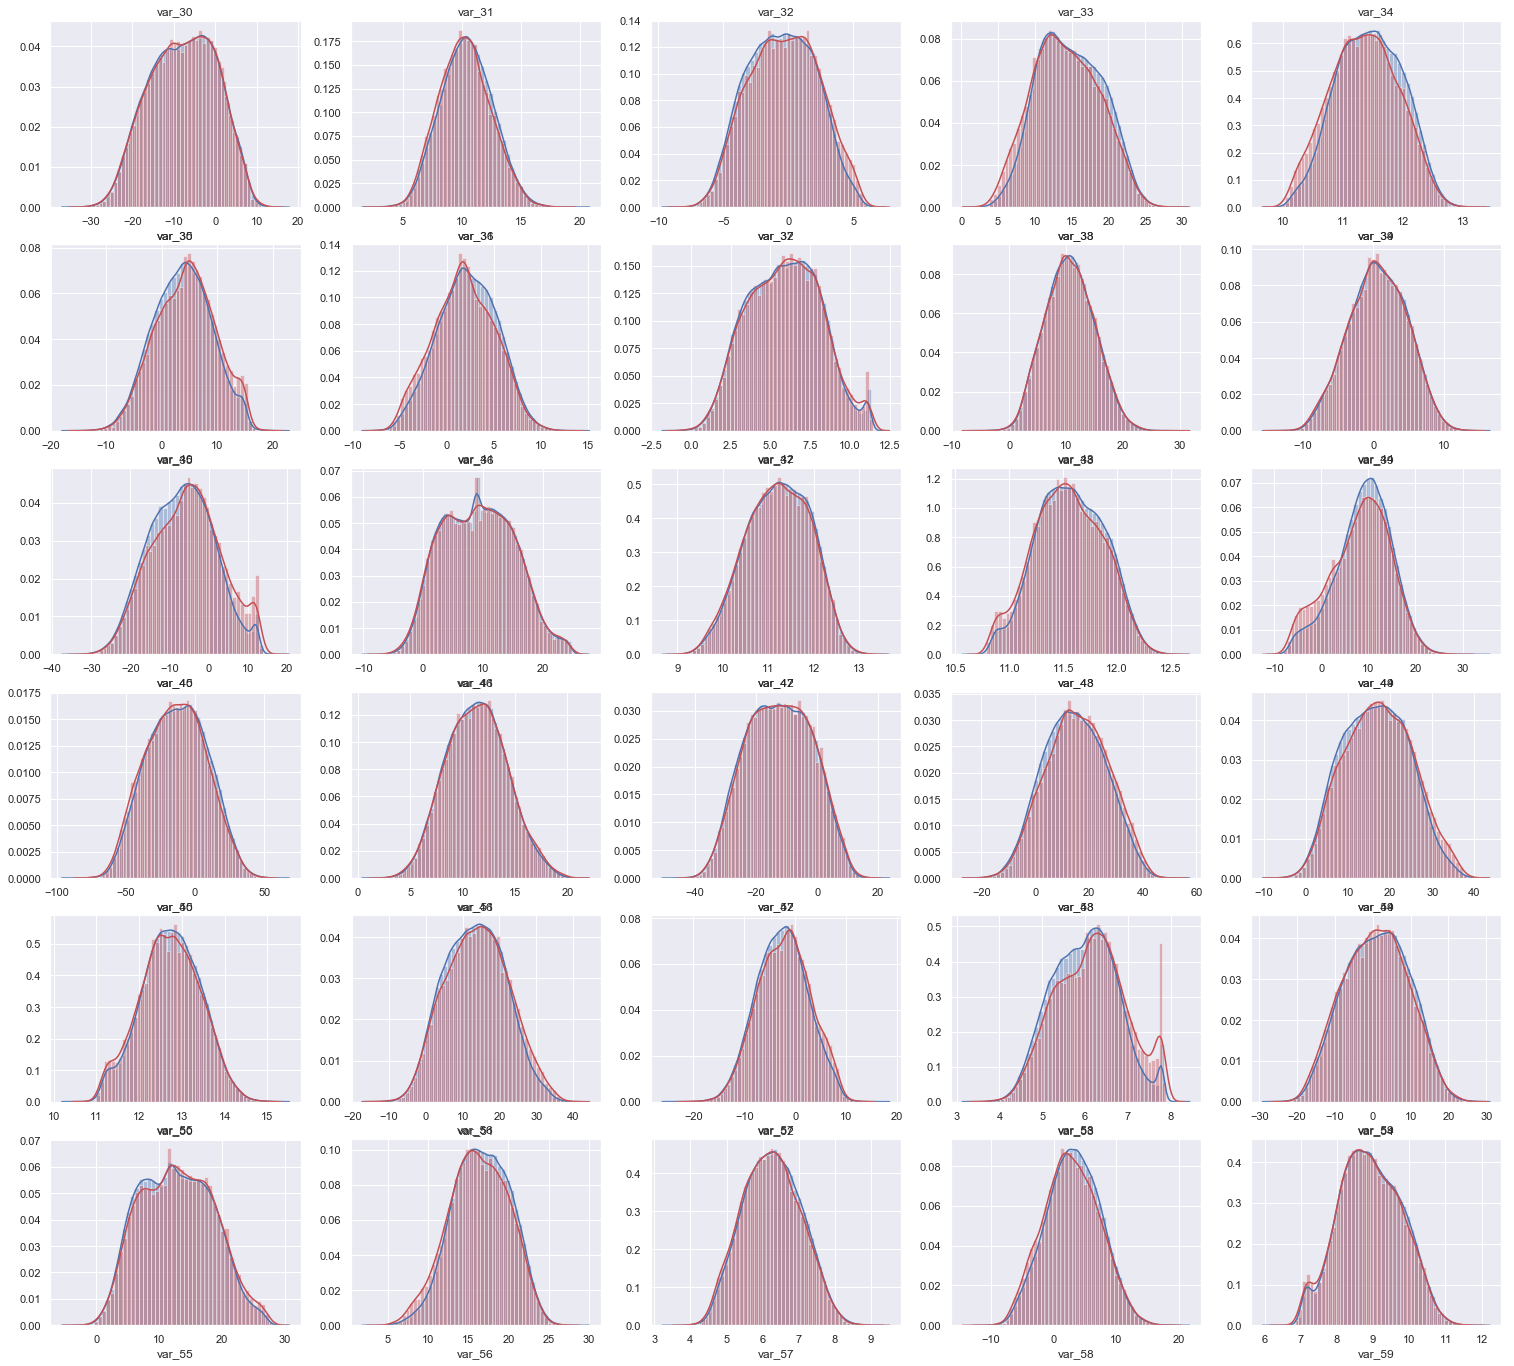

In [249]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


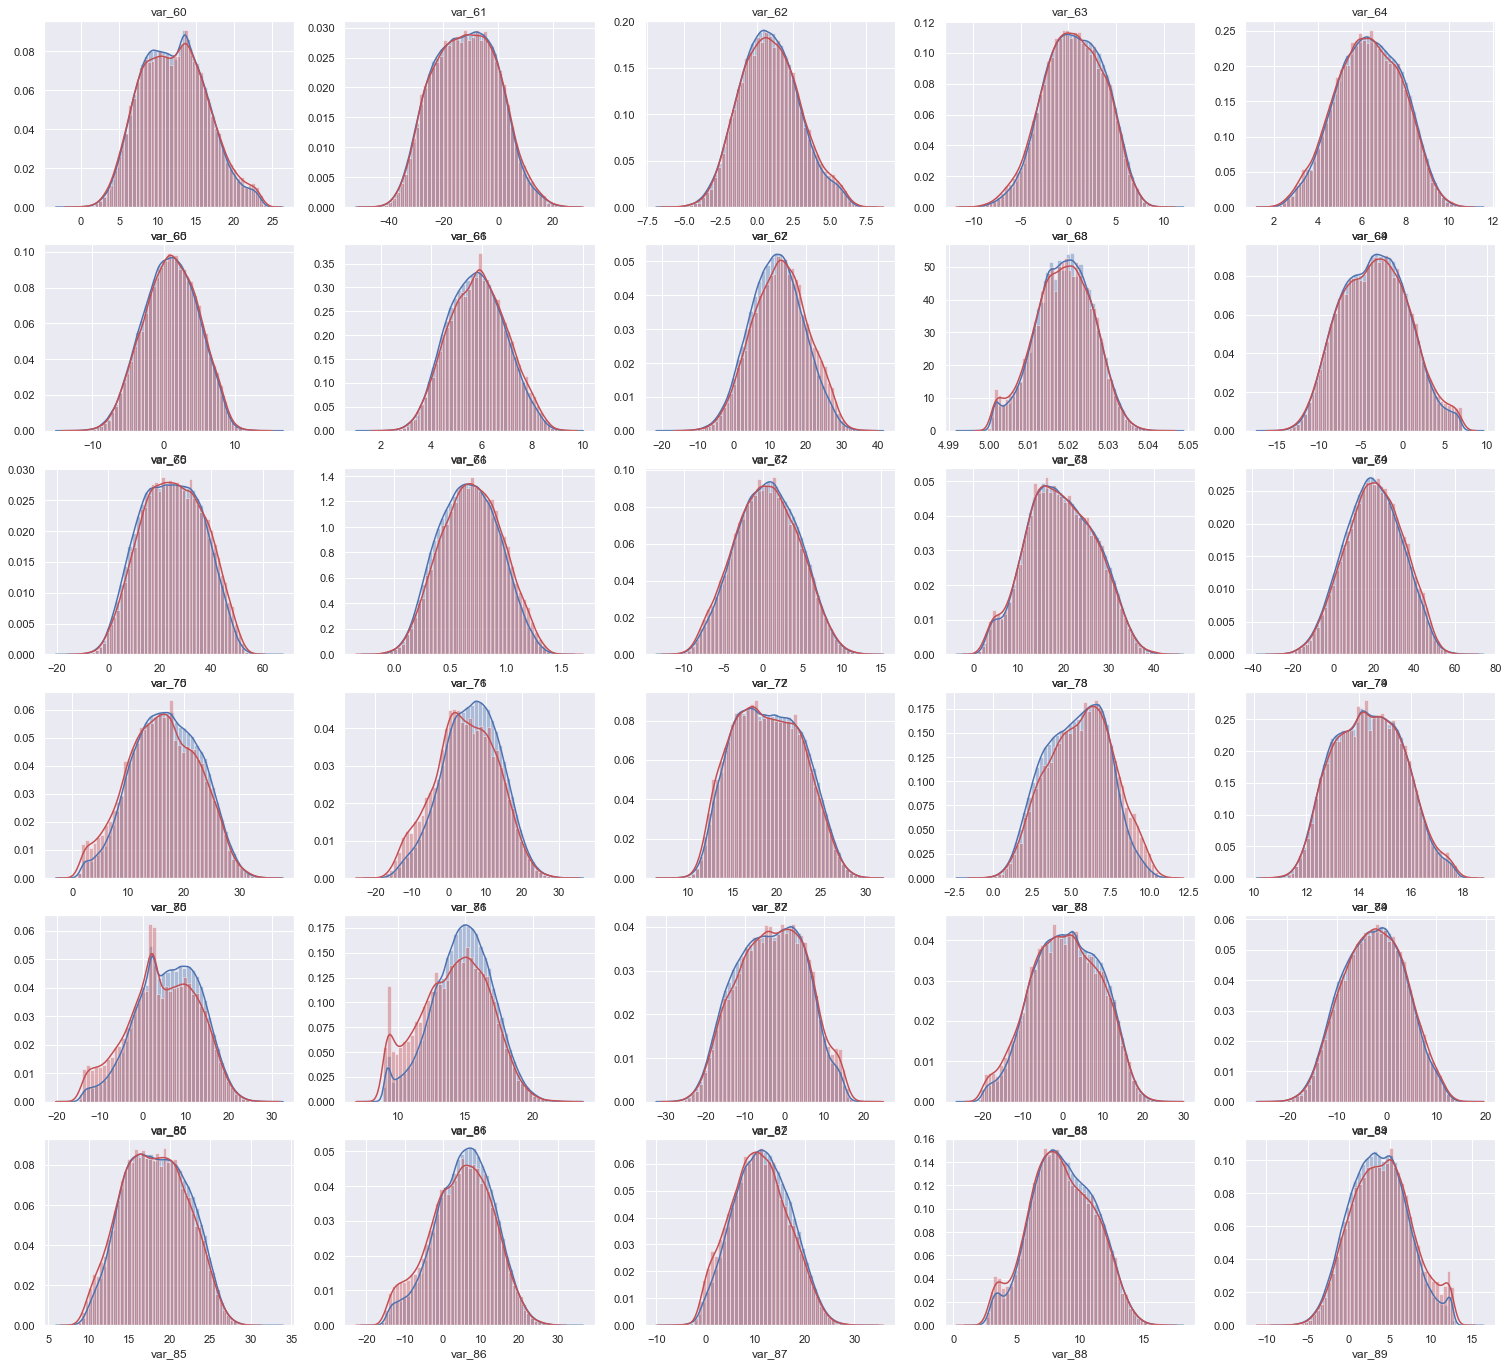

In [250]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


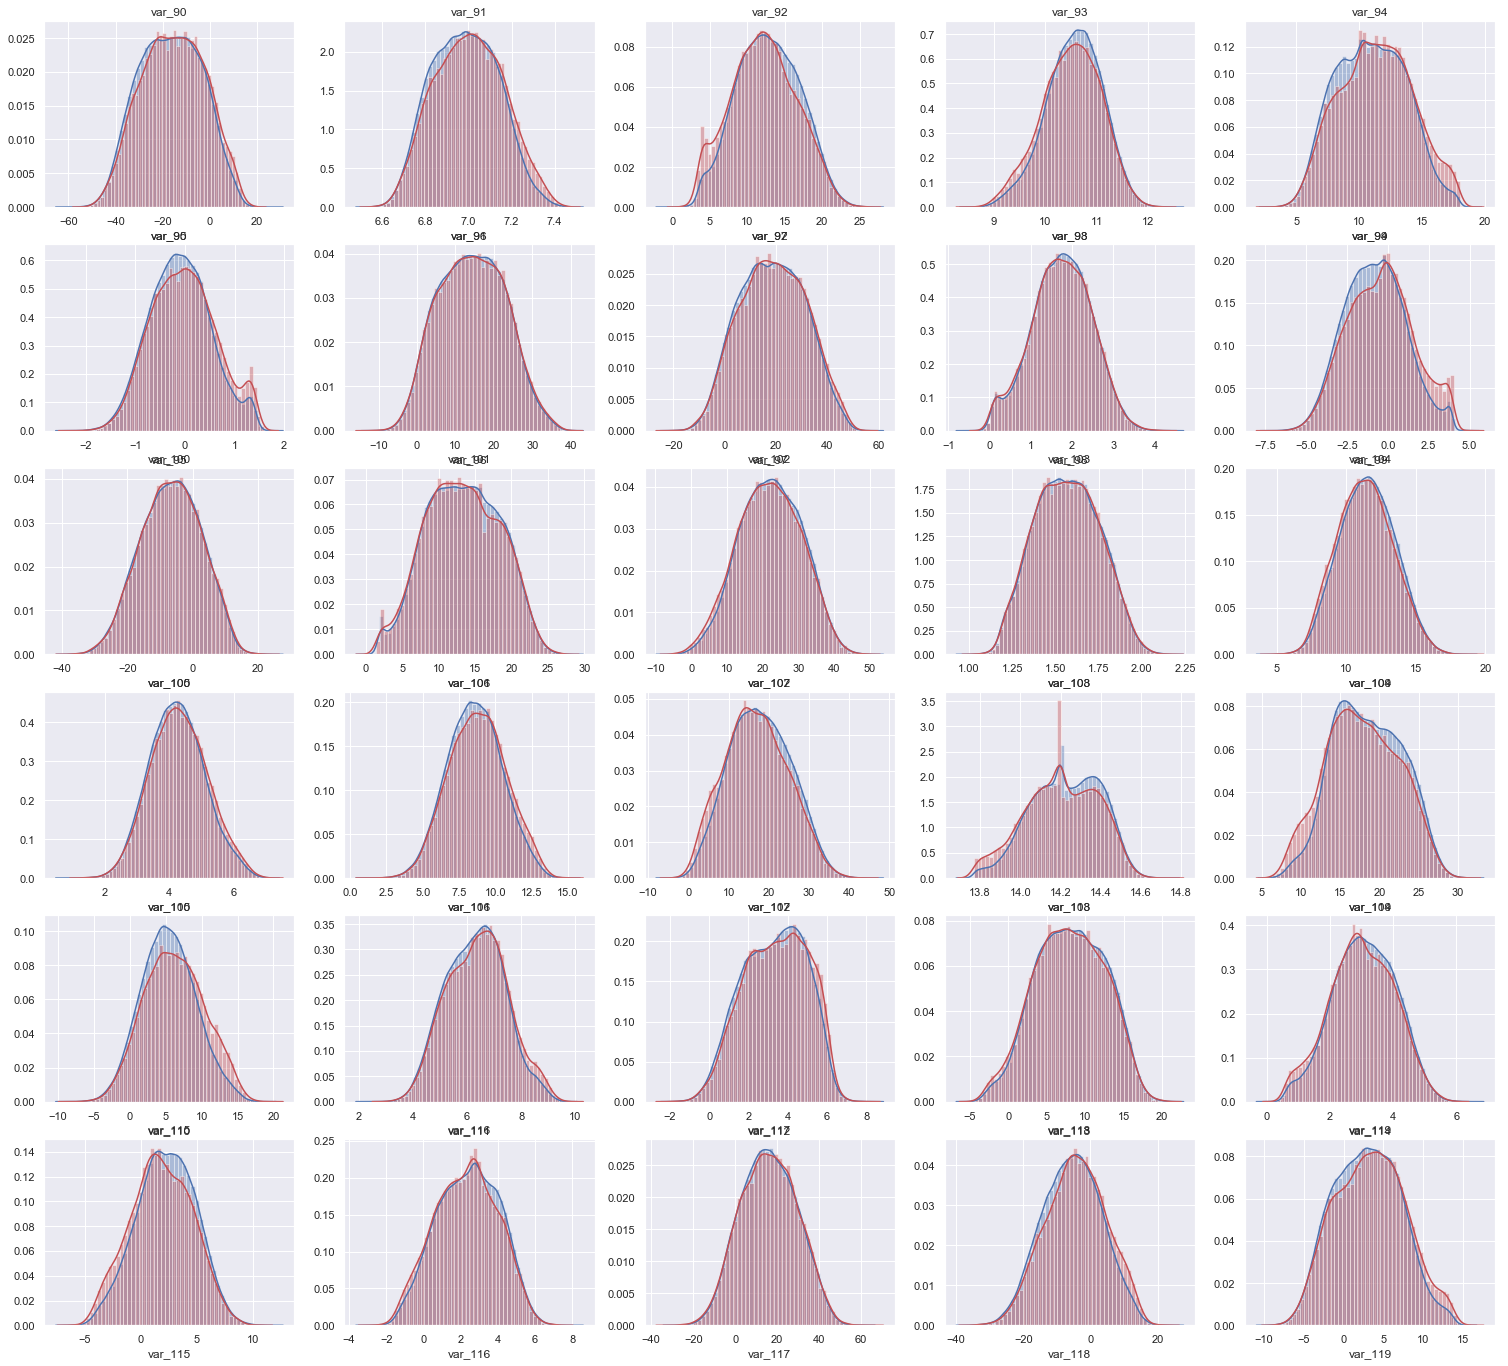

In [251]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


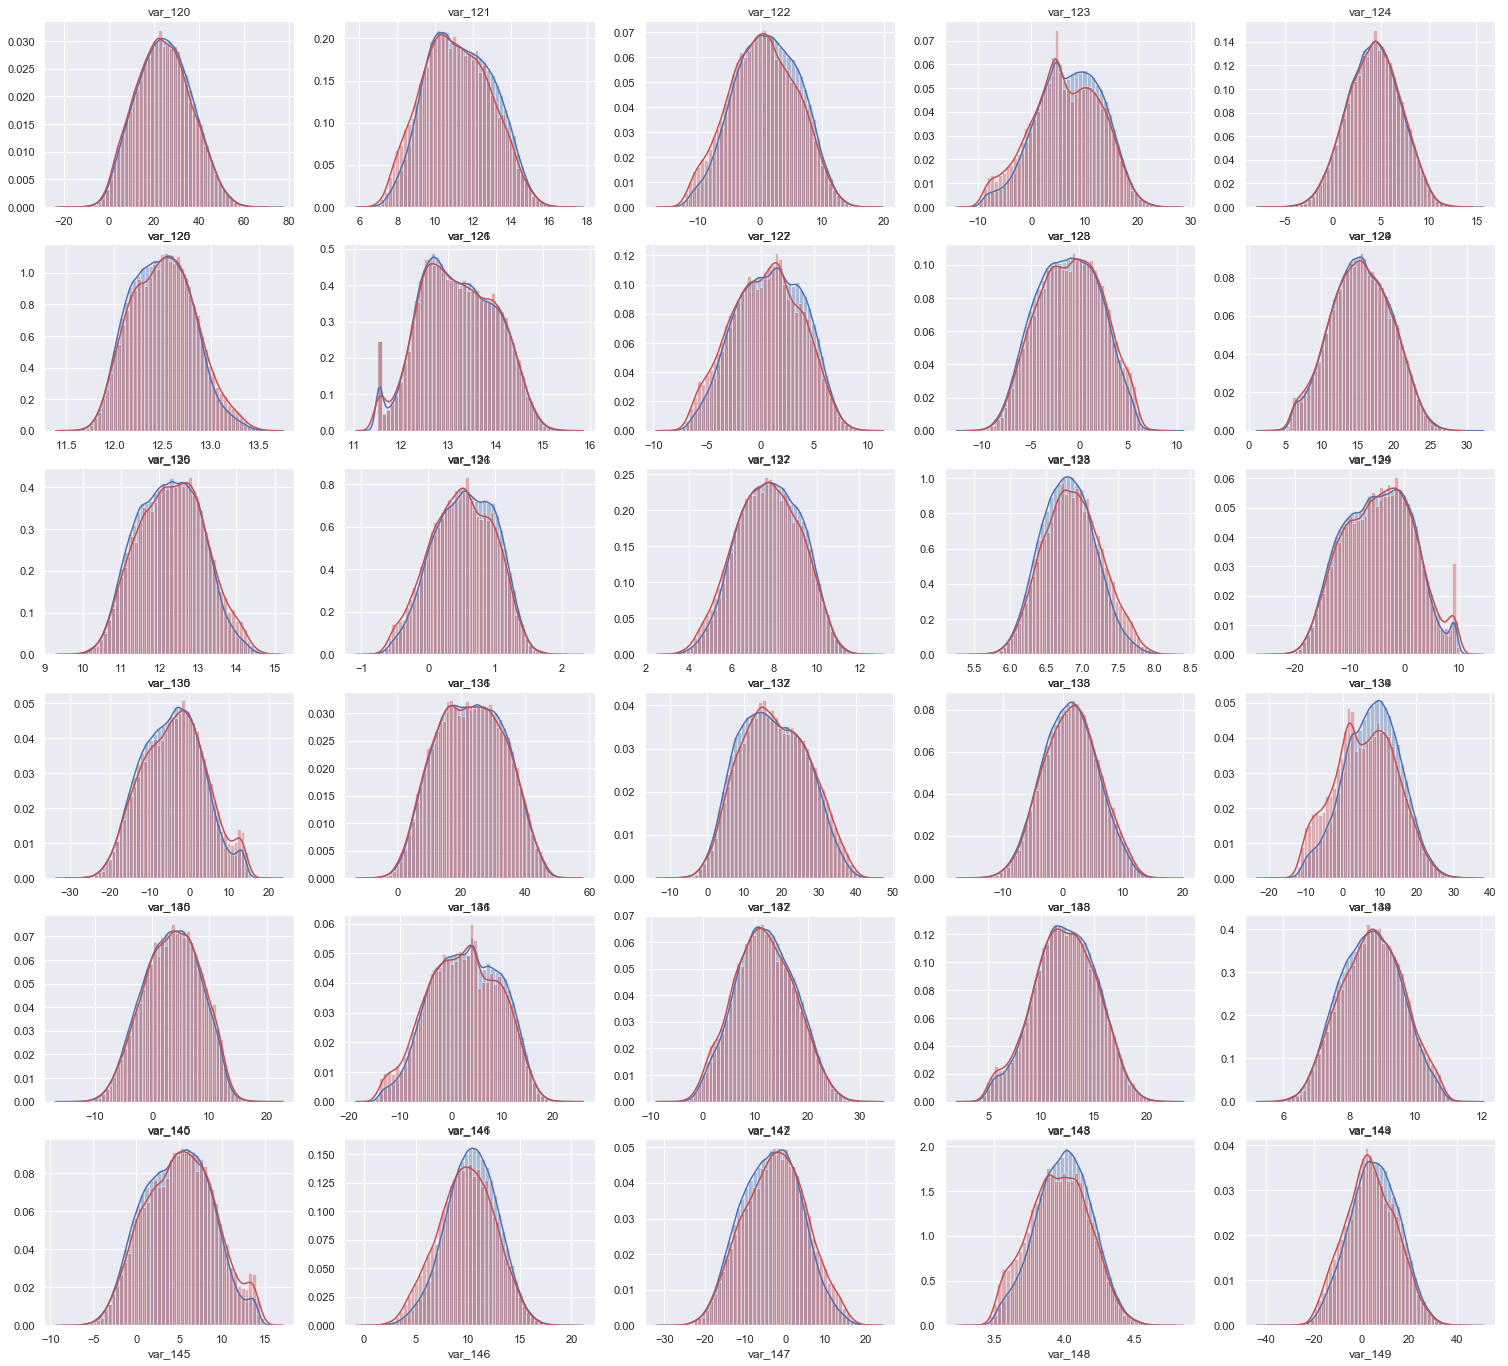

In [252]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


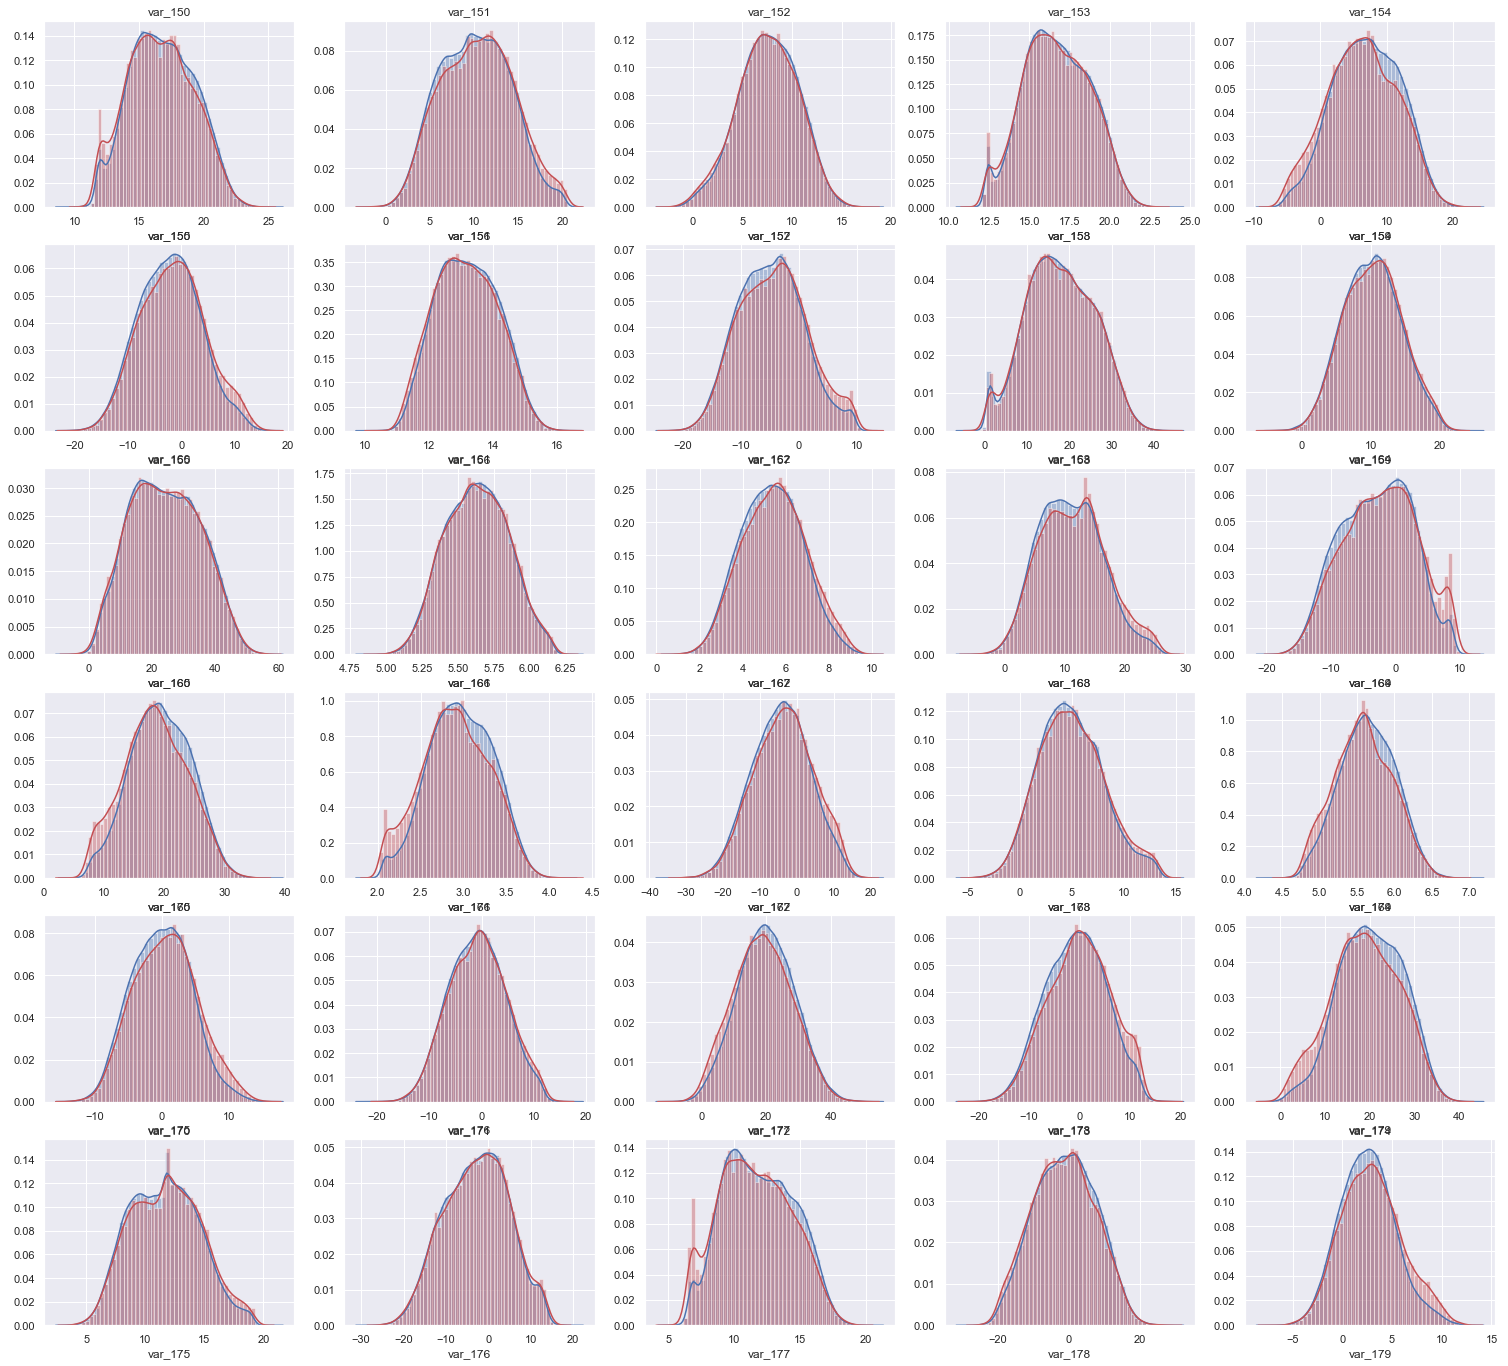

In [253]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(6, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

Distributions of next 30 columns


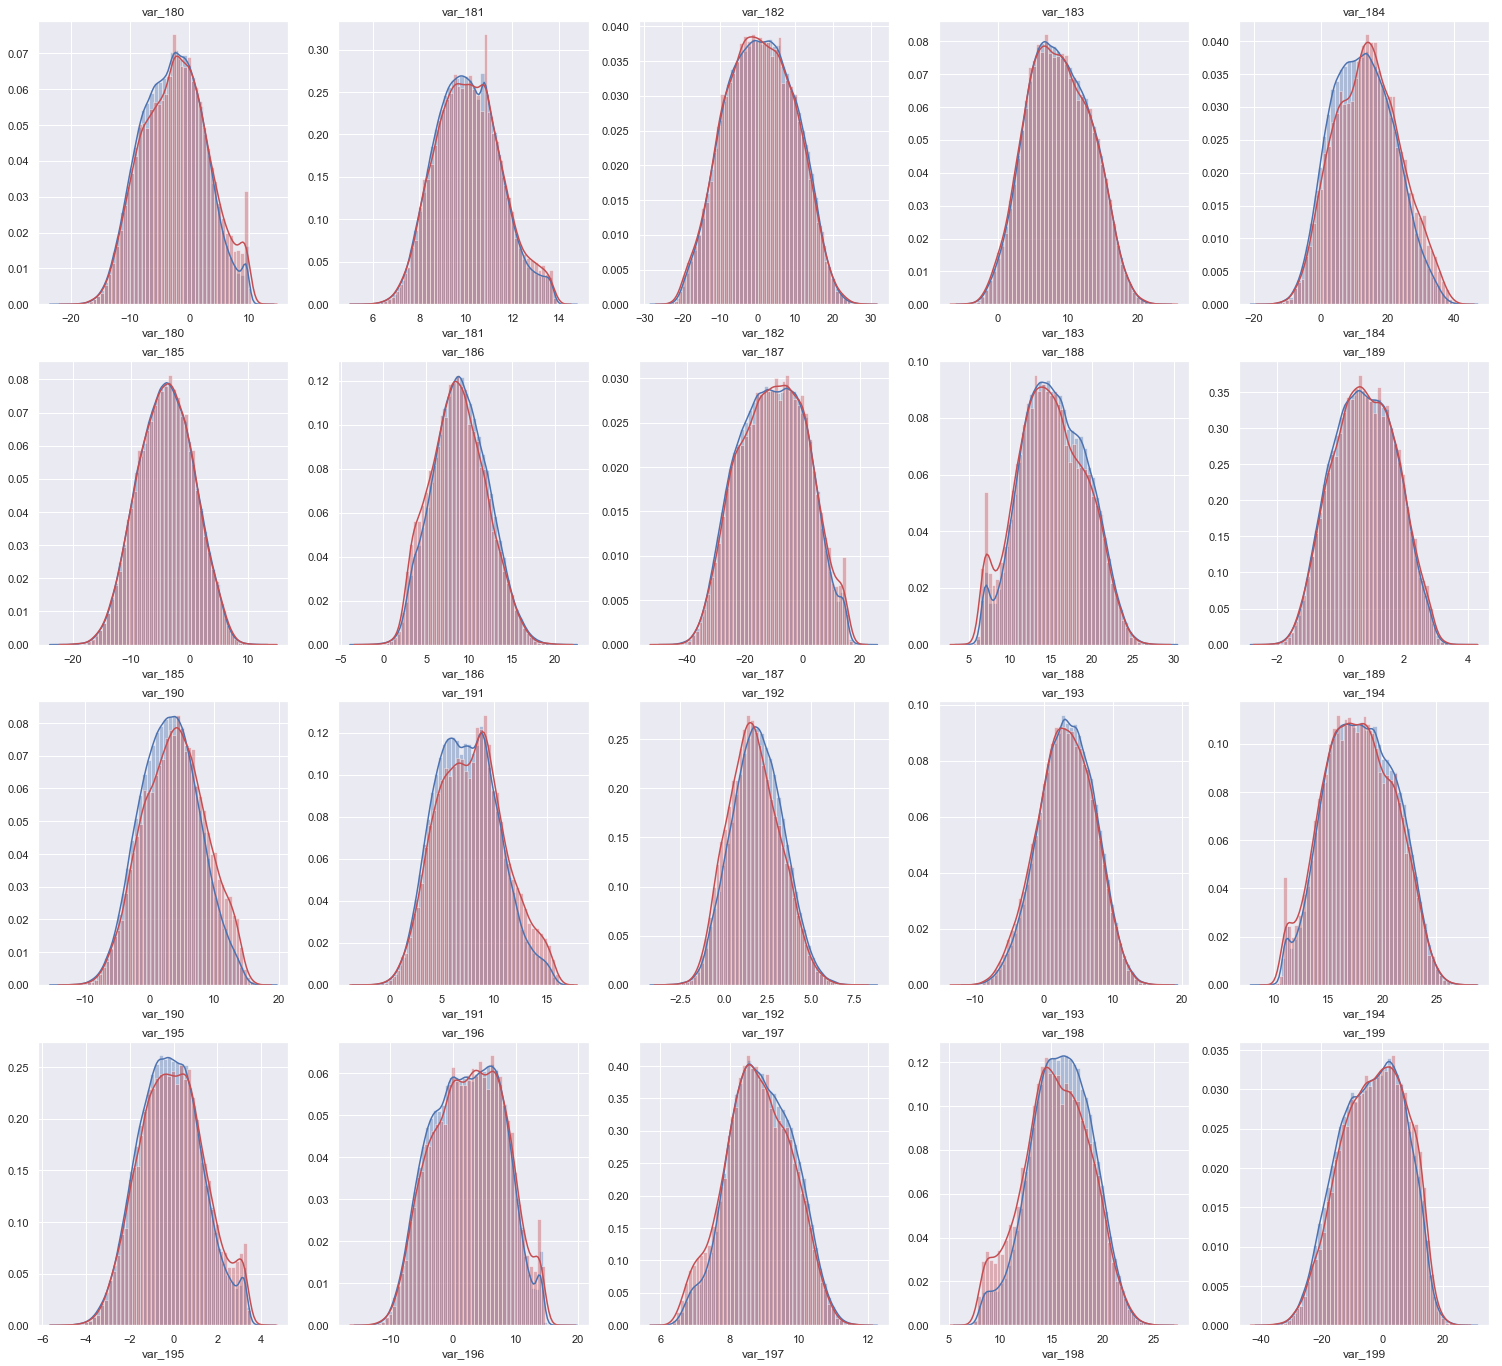

In [258]:
print('Distributions of next 30 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(train.columns)[30*idx+2:30*(idx+1)+2]):
    plt.subplot(4, 5, i + 1)
    sns.distplot(train_0[col], color='b')
    sns.distplot(train_1[col], color='r')
    plt.title(col)

idx += 1

## Is It Categorical ?

In [115]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

In [122]:
temp_0 = []
temp_1 = []
temp_section = []

for col in tqdm_notebook([col for col in train.columns if col not in ['ID_code', 'target']]):
    temp_0.append(train_0[col].unique().__len__())
    temp_1.append(train_1[col].unique().__len__())
    temp_section.append(set(train_0[col].unique()).intersection(set(train_1[col].unique())).__len__())

In [126]:
temp = pd.DataFrame(index=[col for col in train.columns if col not in ['ID_code', 'target']], data={'train0': temp_0, 'train1': temp_1, 'inter_unique': temp_section})

In [127]:
temp['train0_'] = temp.train0 / train_0.__len__()
temp['train1_'] = temp.train1 / train_1.__len__()

## Find Time Series

## Shake Modeling

* Base: CV score: 0.89959 
* Shake : CV score: 0.89959 

In [208]:
train_0 = train[train.target == 0].copy()
train_1 = train[train.target == 1].copy()

In [210]:
np.random.seed(42)

In [211]:
for col in tqdm_notebook([col for col in train.columns if col not in ['ID_code', 'target']]):
    temp = train_0[col].values
    np.random.shuffle(temp)
    train_0[col] = temp

In [232]:
train = train_0.append(train_1).sort_index()

In [233]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}

In [234]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [235]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921283	valid_1's auc: 0.89619
[6000]	training's auc: 0.935776	valid_1's auc: 0.899982
Early stopping, best iteration is:
[6692]	training's auc: 0.938526	valid_1's auc: 0.900164
CV score: 0.90016 
fold n°1
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921568	valid_1's auc: 0.896994
Early stopping, best iteration is:
[5020]	training's auc: 0.931758	valid_1's auc: 0.899399
CV score: 0.89940 
fold n°2
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.920053	valid_1's auc: 0.902223
[6000]	training's auc: 0.934612	valid_1's auc: 0.90526
Early stopping, best iteration is:
[7100]	training's auc: 0.938982	valid_1's auc: 0.905676
CV score: 0.90568 
fold n°3
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.921853	valid_1's auc: 0.894443
[6000]	training's auc: 0.936069	valid_1's auc: 0

## Simple Modeling

In [32]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [33]:
features = [c for c in train.columns if c not in ['ID_code', 'target']]
target = train['target']

In [34]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
    predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.92372	valid_1's auc: 0.897059
Early stopping, best iteration is:
[3770]	training's auc: 0.928265	valid_1's auc: 0.898472
CV score: 0.89847 
fold n°1
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.923475	valid_1's auc: 0.895956
[6000]	training's auc: 0.938596	valid_1's auc: 0.899282
Early stopping, best iteration is:
[6434]	training's auc: 0.940477	valid_1's auc: 0.899403
CV score: 0.89940 
fold n°2
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.92507	valid_1's auc: 0.888958
[6000]	training's auc: 0.939847	valid_1's auc: 0.89289
Early stopping, best iteration is:
[6914]	training's auc: 0.943571	valid_1's auc: 0.893154
CV score: 0.89315 
fold n°3
Training until validation scores don't improve for 200 rounds.
[3000]	training's auc: 0.923194	valid_1's auc: 0.900805
[6000]	training's auc: 0.938306	valid_1's auc: 0.

## 삐꾸 인덱스

In [62]:
temp = train.target.to_frame()
temp['predict'] = oof_lgb
temp = temp.loc[(temp.predict <= 0.1)].reset_index()

In [63]:
temp['new_target']  = 0

In [64]:
temp.loc[temp.target == 1, 'new_target'] = 1

In [65]:
train = temp[['index', 'new_target']].merge(train.reset_index(), on='index', how='left').drop(['index', 'ID_code', 'target'], axis=1)

In [15]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average': False,
    'boost': 'gbdt',
    'feature_fraction_seed': 47,
    'feature_fraction': 0.041,
    'learning_rate': 0.01,
    'max_depth': -1,
    'metric':'binary_logloss',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1,
    'num_threads': 16
}

In [16]:
features = [c for c in train.columns if c not in [""]]
target = train['new_target']

In [17]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

oof_lgb = np.zeros(len(train))
# predictions_lgb = np.zeros(len(test))
feature_importance = pd.DataFrame()

train_columns = [c for c in train.columns if c not in ['ID_code', 'target']]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train, target.values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][train_columns], label=target.iloc[val_idx])

    num_round = 60000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=3000, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    
#     predictions_lgb += clf.predict(test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance = pd.DataFrame()
    fold_importance["Feature"] = train_columns
    fold_importance["importance"] = clf.feature_importance()
    fold_importance["fold"] = fold_ + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    print("CV score: {:<8.5f}".format(roc_auc_score(target.values[val_idx], oof_lgb[val_idx])))
    
print("CV score: {:<8.5f}".format(roc_auc_score(target.values, oof_lgb)))

fold n°0
Training until validation scores don't improve for 200 rounds.
[3000]	training's binary_logloss: 0.0125202	valid_1's binary_logloss: 0.0176091
[6000]	training's binary_logloss: 0.00281793	valid_1's binary_logloss: 0.0052946
[9000]	training's binary_logloss: 0.000996999	valid_1's binary_logloss: 0.00204075
Early stopping, best iteration is:
[10580]	training's binary_logloss: 0.000577614	valid_1's binary_logloss: 0.00119444
CV score: 1.00000 
fold n°1
Training until validation scores don't improve for 200 rounds.
[3000]	training's binary_logloss: 0.0125449	valid_1's binary_logloss: 0.0176089
[6000]	training's binary_logloss: 0.00282113	valid_1's binary_logloss: 0.00530612
[9000]	training's binary_logloss: 0.000998145	valid_1's binary_logloss: 0.00203906
Early stopping, best iteration is:
[10701]	training's binary_logloss: 0.000572436	valid_1's binary_logloss: 0.00118445
CV score: 1.00000 
fold n°2
Training until validation scores don't improve for 200 rounds.
[3000]	training's b

In [38]:
roc_auc_score(cv_test.target, clf.predict(cv_test[train_columns]))

0.9013276627284218

In [41]:
new = pd.DataFrame(clf.predict(cv_test[train_columns]))

In [45]:
te = cv_test.copy()

In [47]:
te['pred'] = clf.predict(cv_test[train_columns])

In [51]:
tt = clf_temp.predict(te[te.pred <= 0.1][train_columns])

In [43]:
new[new[0] <= 0.1]

,0
0,0.006938
2,0.002014
3,0.021930
5,0.055707
6,0.044543
9,0.050246
10,0.025858
11,0.019612
13,0.031741
14,0.025056


In [ ]:
clf_temp.predict()

In [ ]:
clf_temp

In [204]:
temp = target.to_frame()

In [205]:
temp['oof'] = oof_lgb

In [206]:
temp.sort_values('oof')

,new_target,oof
131526,0,0.000026
33874,0,0.000026
54983,0,0.000027
95004,0,0.000027
61147,0,0.000029
126196,0,0.000029
98953,0,0.000030
53676,0,0.000030
60050,0,0.000031
138262,0,0.000031
